In [4]:
import numpy as np
import matplotlib.pyplot as plt
from arc import *
import pickle
import scipy.optimize as opt
import scipy

In [163]:
h = 6.626e-34
e = 1.602e-19
a0 = 5.291e-11
hbar = h/2/np.pi
EH = 4.359744e-18
c = 299792458
kb = 1.380649e-23
me = 9.1093837e-31
epi0 = 8.854e-12
bohr_r = 5.291e-11


<h2>Configuration</h2>

In [105]:
atom_name = 'Cs'
n=50
l = 1
j = 3/2
mj = 3/2

atom_d = 2.5 #um
Omega_Rabi= 1.5*2*np.pi 
pulse_time= 7.65
resolution = 100 # number of phase steps in the pulse

T_atom = 15 #uK
trap_depth = 350 #uK
lambda_trap = 1.064 #um
w0_trap = 1.2 #um


num_samples =1000


In [166]:
if atom_name == "Rb":
    atom = Rubidium()
elif atom_name == "Cs":
    atom = Caesium()
blockade_mrad = find_blockade_Mrad(atom_name, n, atom_d)
R_lifetime = atom.getStateLifetime(n=n,l=l,j=j,temperature=300, includeLevelsUpTo=n+20,s=0.5)*1e6
m_atom = atom.mass

<h2>Find optimized phase</h2>

In [96]:
H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=0, 
                         Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
PhaseGuess = [2*np.pi*0.1122, 1.0431, -0.7318, 0]
time, phase_guess, dt = phase_cosine_generate(*PhaseGuess, H_gen.pulse_time,H_gen.resolution)
# fid_optimize(PhaseGuess, H_gen)
# H_gen.return_fidel
fid, global_phi = H_gen.return_fidel(phases=phase_guess, dt=dt)
print('Infidelity before optimizer:', 1-fid)
opt_out=opt.minimize(fun=fid_optimize,x0=PhaseGuess,args=(H_gen))
phase_params = opt_out.x
# print(phase_params)
infid = opt_out.fun
print('Infidelity after optimizer:', infid) 
print('phase parameter', phase_params)
##%%


Infidelity before optimizer: 0.028824207933536905
Infidelity after optimizer: 0.0034483915270594467
phase parameter [ 0.92203016  0.91111328 -1.22738109 -0.02921375]


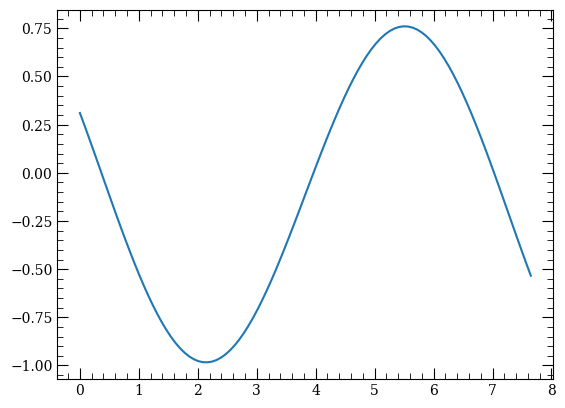

In [97]:
time, phase, dt = phase_cosine_generate(*phase_params, H_gen.pulse_time,H_gen.resolution)
fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt)
plt.plot(time, phase)

<h2>Shot-to-shot detuning</h2>

In [117]:
deltas = np.linspace(0,0.1, 100)
deltas *= Omega_Rabi
infids_mean = []
infids_std  = []
for delta in deltas:
    infids_s = []
    for i in range(num_samples):
        d = sample_gaussian(delta)
        H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=d, 
                             Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
        fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt)
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

Text(0, 0.5, '$1 - \\mathcal{F}$')

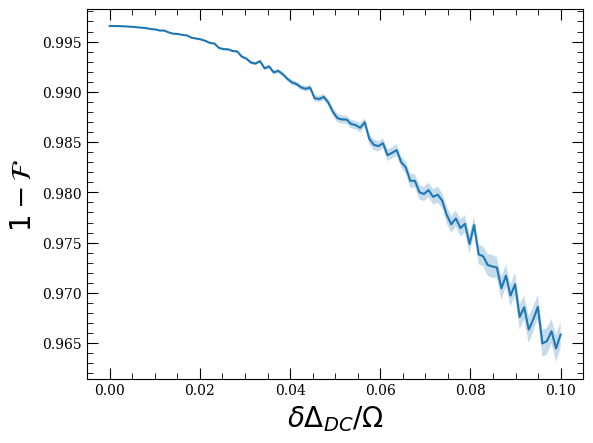

In [125]:
infids_mean = np.asarray(infids_mean)
infids_std  = np.asarray(infids_std)
sem = infids_std / np.sqrt(num_samples)
fractional_delta = deltas/Omega_Rabi
fig, ax = plt.subplots()
ax.plot(fractional_delta, infids_mean, label="mean(1 - fid)")
ax.fill_between(
    fractional_delta,
    infids_mean - sem,
    infids_mean + sem,
    alpha=0.25,
    label="±1 std"
)
ax.set_xlabel(r"$\delta \Delta_{DC}/ \Omega $", fontsize=20)
ax.set_ylabel("$1 - \mathcal{F}$", fontsize=20)
# fig.show()
# ax.legend()

-0.0001570280038832724
0.9961896423700553


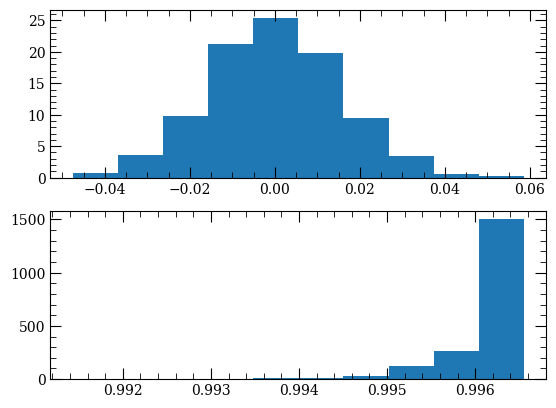

In [110]:
fig, ax = plt.subplots(nrows=2)

ax[0].hist(params, density=True)
ax[1].hist(infids, density= True)
print(np.mean(params))
print(np.mean(infids))

<h2>shot-to-shot Blockade</h2>

In [152]:
infids_mean = []
infids_std  = []
T_atoms = np.linspace(5,20,100)
for T_atom in T_atoms:
    infids_s = []
    sigma_r = sigma_r_um(T_atom, trap_depth, w0_trap)
    sigma_z = sigma_z_um(T_atom, trap_depth, w0_trap, lambda_trap)
    distances = sample_pair_distances(
            n_samples=num_samples,
            sigma_r=sigma_r,
            sigma_z=sigma_z,
            x_offset=atom_d,
            rng=None
    )[0]
    for d in distances:
        blockade = find_blockade_Mrad(atom_name, n, d)
        H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade, r_lifetime=R_lifetime, Delta1=0, 
                             Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
        fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt)
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

Text(0, 0.5, '$1 - \\mathcal{F}$')

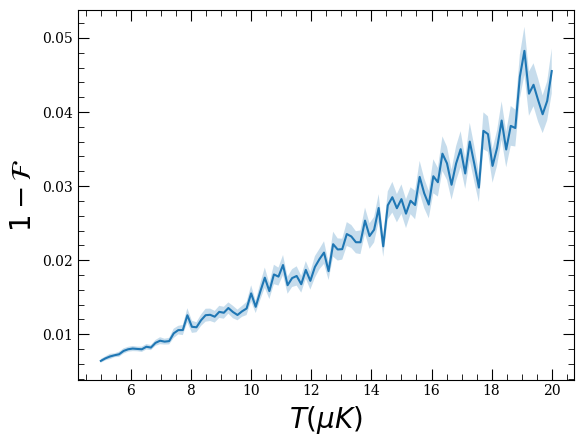

In [156]:
infids_mean = np.asarray(infids_mean)
infids_std  = np.asarray(infids_std)
sem = infids_std / np.sqrt(num_samples)
fig, ax = plt.subplots()
ax.plot(T_atoms, infids_mean, label="mean(1 - fid)")
ax.fill_between(
    T_atoms,
    infids_mean - sem,
    infids_mean + sem,
    alpha=0.25,
    label="±1 std"
)
ax.set_xlabel(r"$T(\mu K)$", fontsize=20)
ax.set_ylabel("$1 - \mathcal{F}$", fontsize=20)

<h2>shot-to-shot Intensity</h2>

In [159]:
delta_omegas = np.linspace(0,0.1, 100)
infids_mean = []
infids_std  = []
for delta_omega in delta_omegas:
    infids_s = []
    for i in range(num_samples):
        omega_scaled = sample_gaussian(delta_omega)
        H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=0, 
                             Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
        fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt, omega_scale=(1-omega_scaled))
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

Text(0, 0.5, '$1 - \\mathcal{F}$')

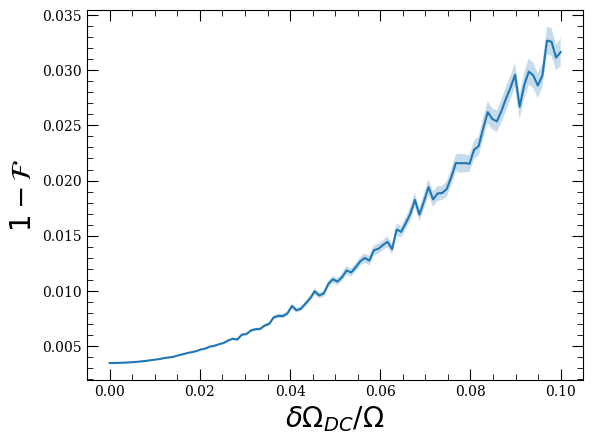

In [173]:
infids_mean = np.asarray(infids_mean)
infids_std  = np.asarray(infids_std)
sem = infids_std / np.sqrt(num_samples)
fig, ax = plt.subplots()
ax.plot(delta_omegas, infids_mean, label="mean(1 - fid)")
ax.fill_between(
    delta_omegas,
    infids_mean - sem,
    infids_mean + sem,
    alpha=0.25,
    label="±1 std"
)
ax.set_xlabel(r"$\delta \Omega_{DC}/ \Omega $", fontsize=20)
ax.set_ylabel("$1 - \mathcal{F}$", fontsize=20)

<h2>Doppler shift</h2>

In [172]:
doppler_shift = 1/lambda_trap/1e-6*np.sqrt(kb*(T_atom*1e-6)/m_atom)
print('doppler shift:', doppler_shift/2/np.pi, 'Hz')

doppler shift: 5291.017469921543 Hz
